# Think Bayes

Copyright 2018 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [42]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

import numpy as np
import pandas as pd

# import classes from thinkbayes2
from thinkbayes2 import Pmf, Cdf, Suite, Joint

from thinkbayes2 import MakePoissonPmf, EvalBinomialPmf, MakeMixture

import thinkplot

## Cats and rats an elephants

Suppose there are six species that might be in a zoo: lions and tigers and bears, and cats and rats and elephants.  Every zoo has a subset of these species, and every subset is equally likely.

One day we visit a zoo and see 3 lions, 2 tigers, and one bear.  Assuming that every animal in the zoo has an equal chance to be seen, what is the probability that the next animal we see is an elephant?



In [43]:
from itertools import combinations

def all_combos(s):
    n = len(s)
    for r in range(1, n+1):
        for comb in combinations(s, r):
            yield list(comb)

In [44]:
def enumerate_zoos(all_species, present):
    """Enumerate all zoos that contain `present`.
    
    all_species: sequence of all species
    present: sequence of species present
    
    yields: possible zoos
    """
    present = set(present)
    for combo in all_combos(species):
        intersect = set(combo) & present
        if len(intersect) == len(present):
            yield len(combo), combo

In [45]:
species = 'LTBCRE'
present = 'LTB'

for n, zoo in enumerate_zoos(species, present):
    print(n, zoo)

3 ['L', 'T', 'B']
4 ['L', 'T', 'B', 'C']
4 ['L', 'T', 'B', 'R']
4 ['L', 'T', 'B', 'E']
5 ['L', 'T', 'B', 'C', 'R']
5 ['L', 'T', 'B', 'C', 'E']
5 ['L', 'T', 'B', 'R', 'E']
6 ['L', 'T', 'B', 'C', 'R', 'E']


In [46]:
from thinkbayes2 import Dirichlet

In [47]:
def random(dirichlet):
    """Generates a random variate from this distribution.

    Returns: normalized vector of fractions
    """
    p = np.random.gamma(dirichlet.params)
    return p / p.sum()

In [48]:
d4 = Dirichlet(4)

In [49]:
p = random(d4)

array([0.16977302, 0.00833748, 0.23169054, 0.59019896])

In [50]:
data = [3, 2, 1, 0]
m = sum(data)

6

In [51]:
from scipy.stats import multinomial

In [52]:
multinomial(m, p).pmf(data)

4.728627148818237e-06

In [53]:
data = [3, 2, 1]

[3, 2, 1]

In [54]:
def zero_pad(a, n):
    """Why does np.pad have to be so complicated?
    """
    res = np.zeros(n)
    res[:len(a)] = a
    return res

zero_pad(data, 4)

array([3., 2., 1., 0.])

In [55]:
def sample_likelihood(dirichlet, data, iters=1000):
    data = zero_pad(data, dirichlet.n)
    m = np.sum(data)
    likes = [multinomial(m, random(dirichlet)).pmf(data) 
             for i in range(iters)]
    return np.mean(likes)

In [56]:
sample_likelihood(d4, data)

0.011250027071160526

In [57]:
class Zoo(Suite):
    
    def Likelihood(self, data, hypo):
        """
        data: sequence of counts
        hypo: Dirichlet object
        """
        return sample_likelihood(hypo, data)

In [58]:
suite = Zoo([Dirichlet(n, label=''.join(zoo))
        for n, zoo in enumerate_zoos(species, present)])

def print_zoos(suite):
    for d, p in suite.Items():
        print(p, d.label)
        
print_zoos(suite)

0.125 LTB
0.125 LTBC
0.125 LTBR
0.125 LTBE
0.125 LTBCR
0.125 LTBCE
0.125 LTBRE
0.125 LTBCRE


In [59]:
suite.Update(data)

0.010927490763901811

In [60]:
for hypo in suite:
    hypo.Update(data)

In [61]:
print_zoos(suite)

0.40356031546379767 LTB
0.13513933478713452 LTBC
0.13986920841340222 LTBR
0.1329451199410315 LTBE
0.05128877877274178 LTBCR
0.06057562960408975 LTBCE
0.0512604090424378 LTBRE
0.025361203975364552 LTBCRE


In [62]:
pmf_n = Pmf()
for d, p in suite.Items():
    pmf_n[d.n] += p

3.8102869099062002


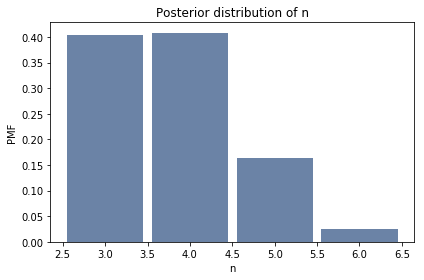

In [63]:
thinkplot.Hist(pmf_n)
print(pmf_n.Mean())
thinkplot.decorate(xlabel='n', 
                   ylabel='PMF', 
                   title='Posterior distribution of n')

In [64]:
def enumerate_posterior(suite):
    for d, p in suite.Items():
        mean = d.Mean()
        index = d.label.find('E')
        p_elephant = 0 if index == -1 else mean[index]
        yield d, p, p_elephant

In [65]:
for d, p, p_elephant in enumerate_posterior(suite):
    print(d.label, p, p_elephant)

LTB 0.40356031546379767 0
LTBC 0.13513933478713452 0
LTBR 0.13986920841340222 0
LTBE 0.1329451199410315 0.1
LTBCR 0.05128877877274178 0
LTBCE 0.06057562960408975 0.09090909090909091
LTBRE 0.0512604090424378 0.09090909090909091
LTBCRE 0.025361203975364552 0.08333333333333333


In [66]:
total = np.sum(p * p_elephant 
               for d, p, p_elephant in enumerate_posterior(suite))

0.025574858262946643